<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/RNN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D,\
LSTM,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-11-23 14:10:02--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-11-23 14:10:02 (24.5 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/yeesem/Time-Series-Data-Analysis/main/airline_passengers.csv",index_col = 'Month',parse_dates = True)

In [6]:
df['LogPassengers'] = np.log(df['Passengers'])

In [7]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [8]:
#Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [9]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [10]:
#Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t : t + T]
  X.append(x)
  y = series[t + T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)

print("X.shape: ",X.shape," Y shape: ",Y.shape)

X.shape:  (133, 10, 1)  Y shape:  (133,)


In [11]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [12]:
#RNN
i = Input(shape = (T,1))
x = LSTM(24)(i)
x = Dense(1)(x)

model = Model(i,x)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


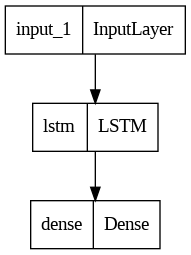

In [14]:
tf.keras.utils.plot_model(model)

In [15]:
r = model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [16]:
r = model.fit(
    XTrain,
    YTrain,
    epochs = 100,
    validation_data = (XTest,YTest)
)

Epoch 1/100
4/4 [==============================] - 11s 334ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 3/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0107 - val_loss: 0.0101
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0105 - val_loss: 0.0097
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 6/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 7/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 8/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 9/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0087 - val_loss: 0.0077
Epoch 10/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 11/100
4/4 

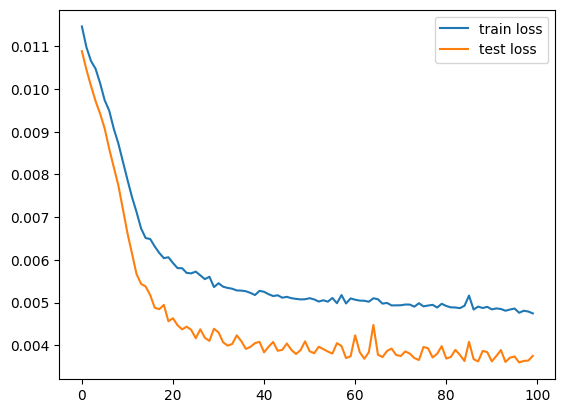

In [17]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [18]:
#First T+1 values are not predictable
train_idx[:T+1] = False

In [19]:
PTrain = model.predict(XTrain).flatten()
PTest = model.predict(XTest).flatten()

1/1 [==============================] - 0s 31ms/step


In [20]:
#Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [21]:
#Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [22]:
#1-step forecast
df.loc[train_idx,'1step_train'] = prev[train_idx] + PTrain
df.loc[test_idx,'1step_test'] = prev[test_idx] + PTest

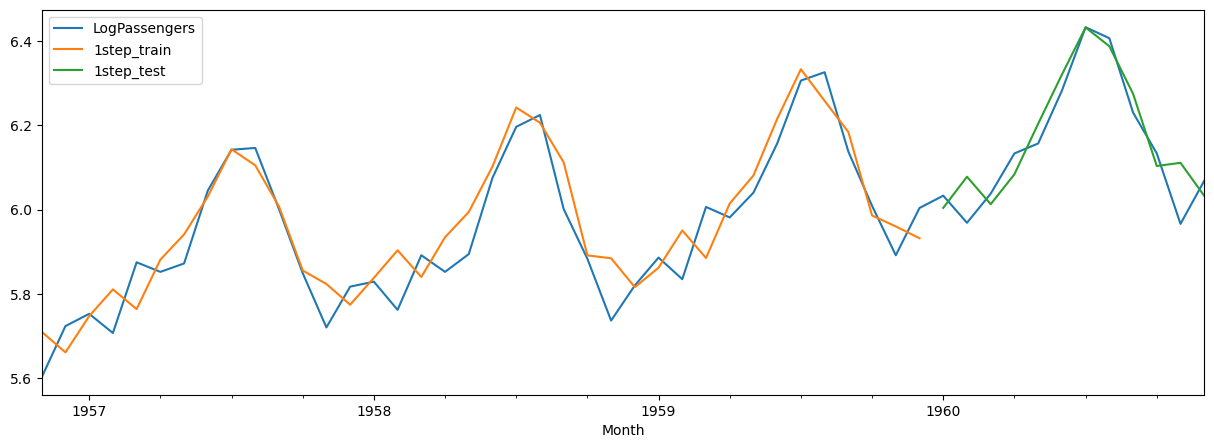

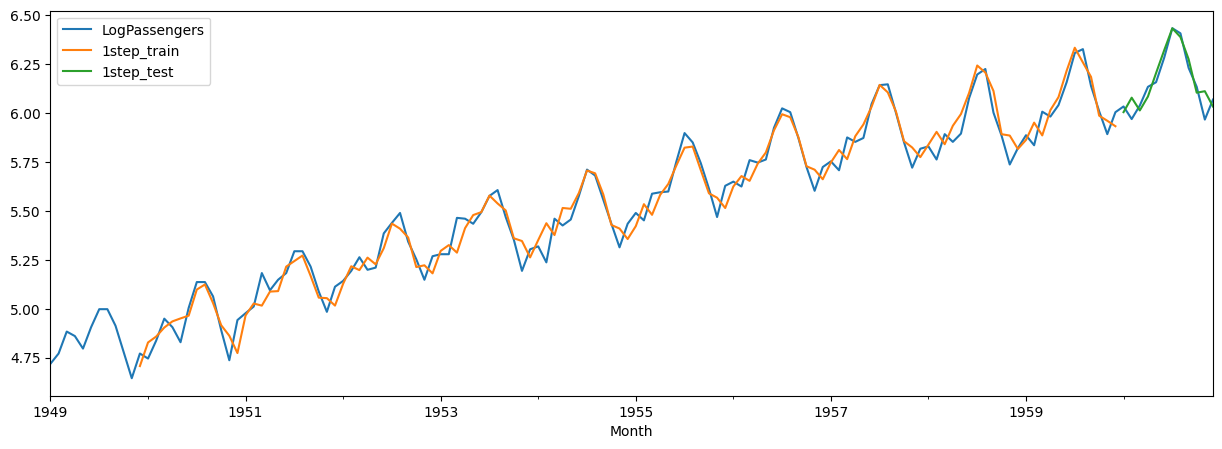

In [23]:
#plot 1-step forecast
cols = [
    'LogPassengers',
    '1step_train',
    '1step_test'
]

df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));

In [24]:
#multi step predictions
multistep_predictions = []

#first test input
x_last = XTest[0]

for t in range(len(multistep_predictions) < NTest):
    p = model.predict(x_last.reshape(1,-1,1))[0]

    #Update the predictions list
    multistep_predictions.append(p)

    #Update the new input
    x_last = XTest[0] = np.roll(x_last,-1)
    x_last[-1] = p

1/1 [==============================] - 0s 37ms/step


In [25]:
df.loc[test_idx,'multistep'] = last_train + np.cumsum(multistep_predictions)

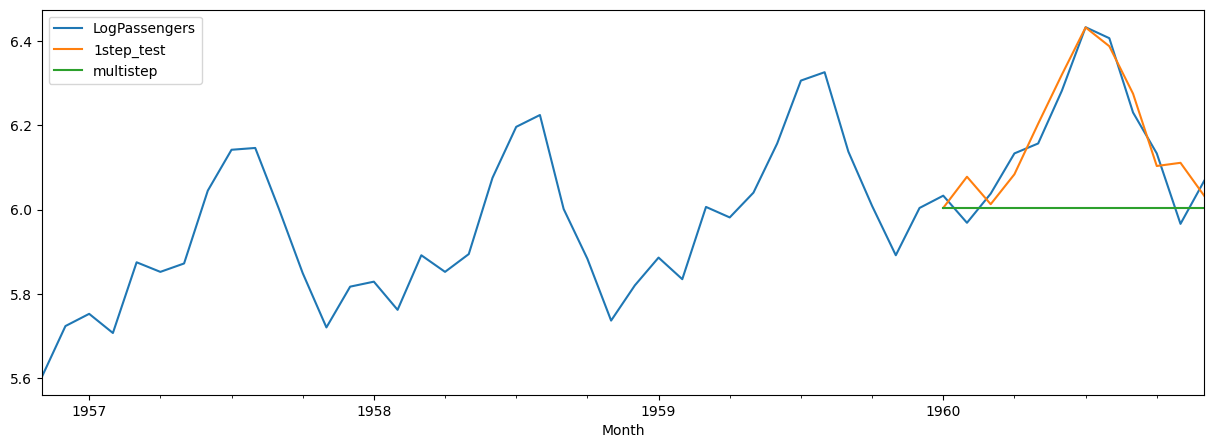

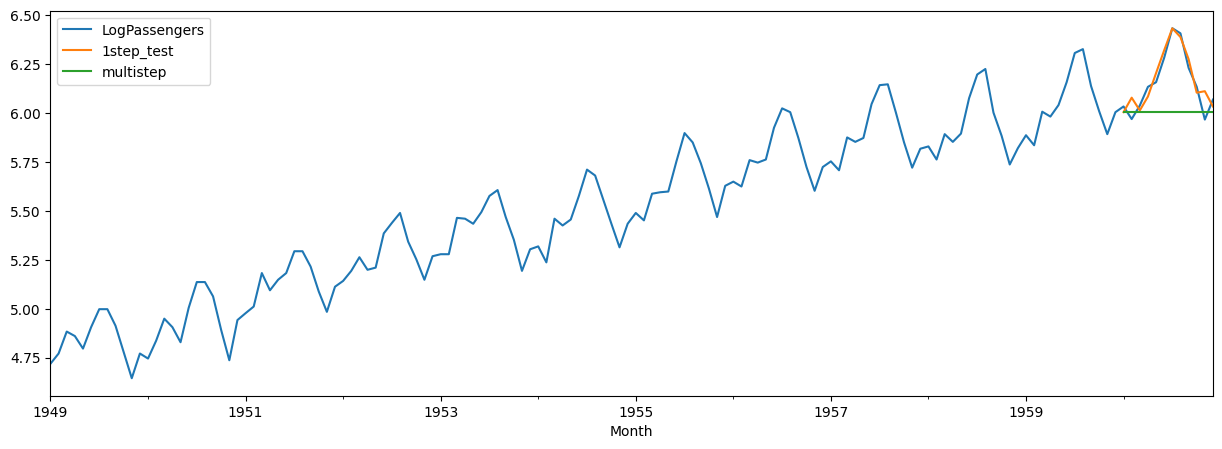

In [26]:
cols = [
    'LogPassengers',
    '1step_test',
    'multistep'
]
df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));

In [27]:
#Make the multi-output supervised dataset
Tx = T
Ty = NTest
X = []
Y = []

for t in range(len(series) - Tx - Ty):
  x = series[t : t + Tx]
  X.append(x)
  y = series[t + Tx : t + Tx + Ty]
  Y.append(y)

X = np.array(X).reshape(-1,Tx,1)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)

print("X shape: ",X.shape, " Y shape: ",Y.shape)

X shape:  (121, 10, 1)  Y shape:  (121, 12)


In [28]:
XTrain_m,YTrain_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [29]:
#RNN
i = Input(shape = (Tx,1))
x = LSTM(24,return_sequences = True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

model = Model(i,x)

In [30]:
check_point = ModelCheckpoint(
    'best_model',monitor = 'val_loss',save_best_model = True
)

In [31]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [33]:
r = model.fit(
    XTrain_m,
    YTrain_m,
    epochs = 250,
    validation_data = (XTest_m,YTest_m),
    callbacks = [check_point]
)

Epoch 1/250
4/4 [==============================] - 4s 1s/step - loss: 0.0056 - val_loss: 0.0049
Epoch 2/250
4/4 [==============================] - 3s 927ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 3/250
4/4 [==============================] - 3s 1s/step - loss: 0.0055 - val_loss: 0.0048
Epoch 4/250
4/4 [==============================] - 3s 924ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 5/250
4/4 [==============================] - 3s 1s/step - loss: 0.0054 - val_loss: 0.0044
Epoch 6/250
4/4 [==============================] - 4s 1s/step - loss: 0.0054 - val_loss: 0.0048
Epoch 7/250
4/4 [==============================] - 3s 912ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 8/250
4/4 [==============================] - 3s 931ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 9/250
4/4 [==============================] - 4s 1s/step - loss: 0.0052 - val_loss: 0.0041
Epoch 10/250
4/4 [==============================] - 4s 1s/step - loss: 0.0052 - val_loss: 0.0039
Epoch 11/250
4/4 [=========

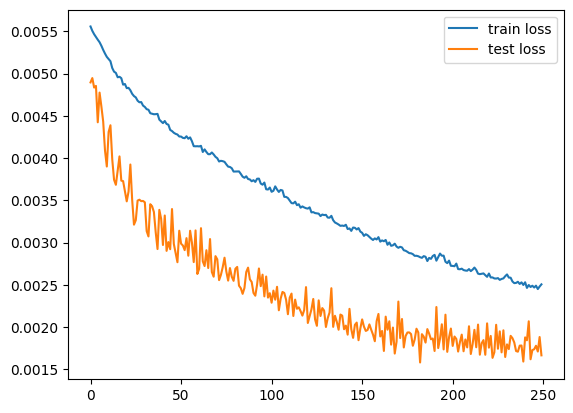

In [34]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [35]:
#Load best model
best_model = tf.keras.models.load_model('best_model')

In [36]:
PTrain = best_model.predict(XTrain_m)
PTest = best_model.predict(XTest_m)

1/1 [==============================] - 0s 25ms/step


In [37]:
PTrain.shape,PTest.shape

((120, 12), (1, 12))

In [38]:
#Make sure the data is in the right shape
PTrain = PTrain[:,0]
PTest = PTest[0]

In [39]:
#Save multi-output forecast
df.loc[test_idx,'multioutput'] = last_train + \
np.cumsum(PTest)

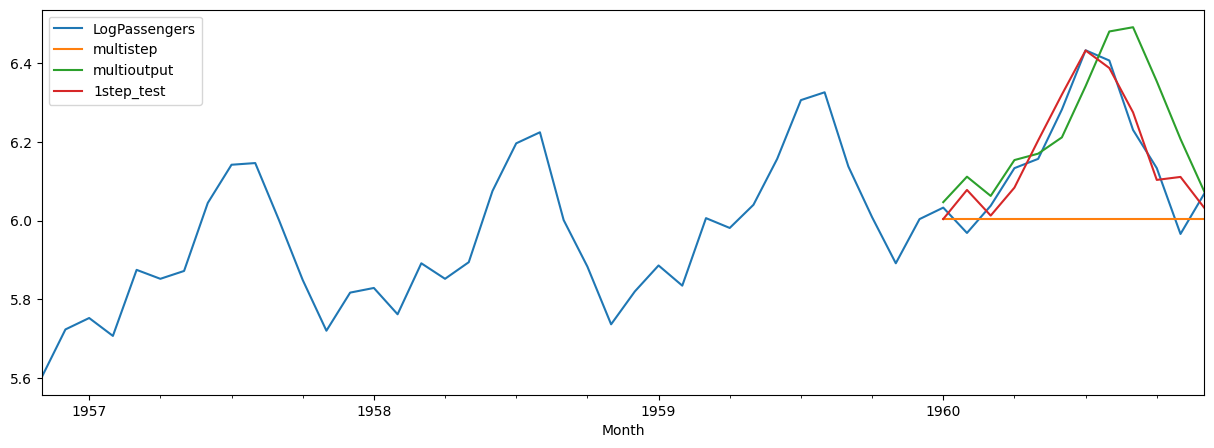

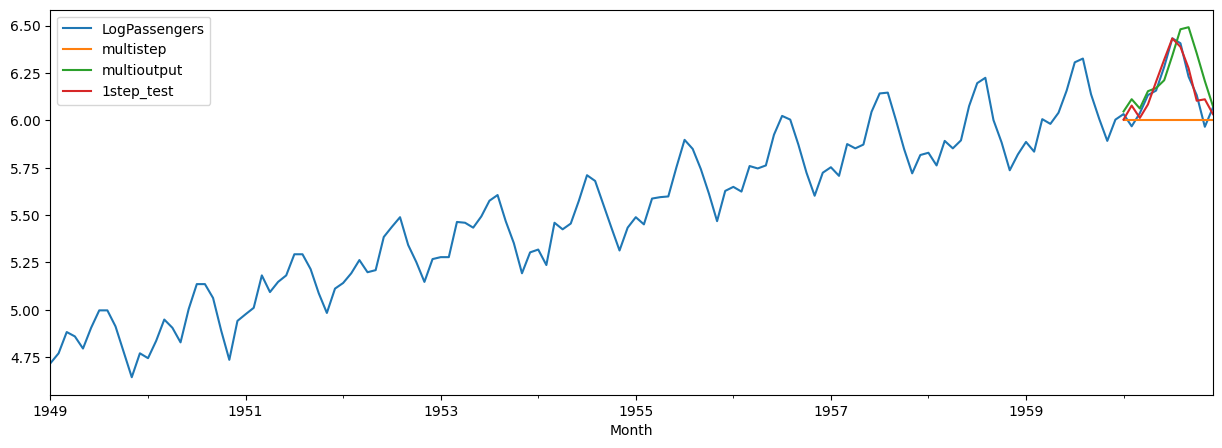

In [40]:
#Plot all forecast
cols = [
    'LogPassengers',
    'multistep',
    'multioutput',
    '1step_test'
]
df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));

In [43]:
#RNN
i = Input(shape = (Tx,1))
x = LSTM(16,return_sequences = True)(i)
x = LSTM(16,return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

model = Model(i,x)

In [44]:
check_point = ModelCheckpoint(
    'best_model',monitor = 'val_loss',save_best_only = True
)

In [45]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [46]:
r = model.fit(
    XTrain_m,
    YTrain_m,
    epochs = 300,
    callbacks = [check_point],
    validation_data = (XTest_m,YTest_m)
)

Epoch 1/300
4/4 [==============================] - 12s 2s/step - loss: 0.0115 - val_loss: 0.0113
Epoch 2/300
4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0113
Epoch 3/300
4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0113
Epoch 4/300
4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0112
Epoch 5/300
4/4 [==============================] - 7s 2s/step - loss: 0.0113 - val_loss: 0.0112
Epoch 6/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 7/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 8/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 9/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 10/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 11/300
4/4 [==========

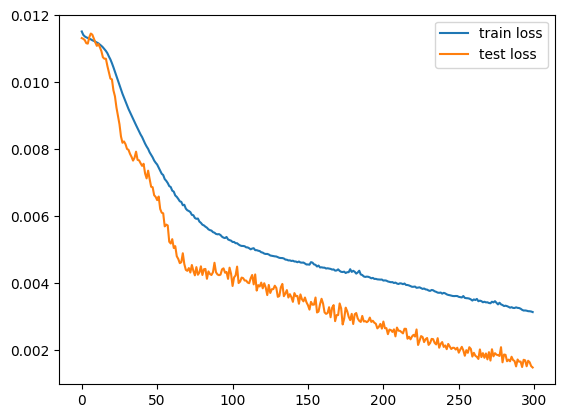

In [47]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [48]:
#Load the best model
best_model = tf.keras.models.load_model('best_model')

In [49]:
PTrain = model.predict(XTrain_m)
PTest = model.predict(XTest_m)

1/1 [==============================] - 0s 27ms/step


In [50]:
PTrain = PTrain[:,0]
PTest = PTest[0]

In [51]:
#Save multi-output forecast to dataframe
df.loc[test_idx,'multioutput2'] = last_train + \
np.cumsum(PTest)

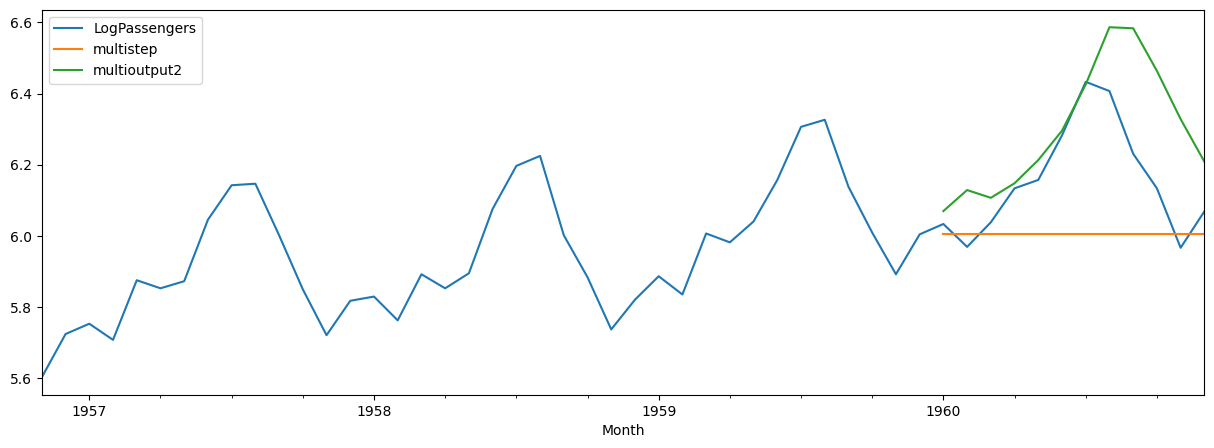

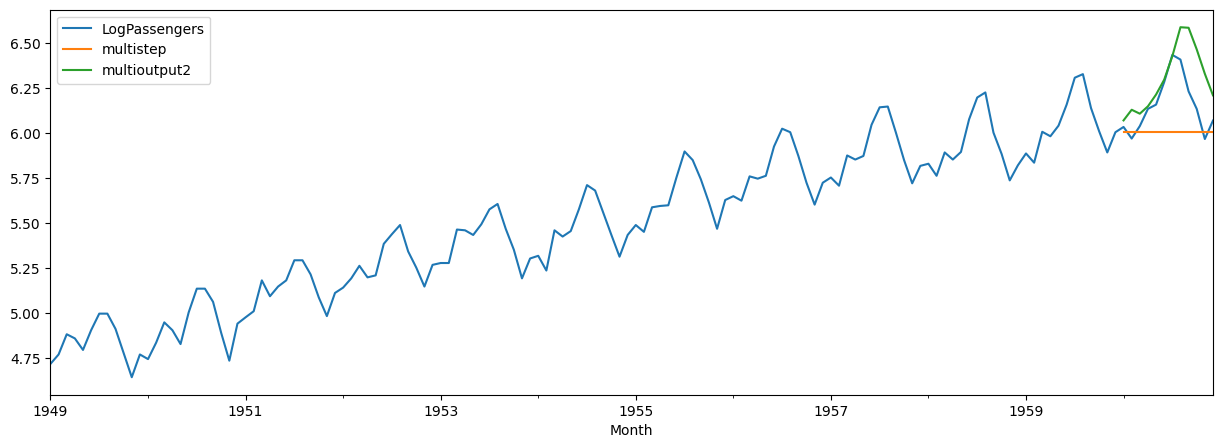

In [52]:
#Plot all the forecast
cols = [
    'LogPassengers',
    'multistep',
    'multioutput2'
]
df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));

In [53]:
#MAPE
test_log_pass = df.iloc[-NTest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multistep']
)
print("Multi-step    MAPE: ",mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multioutput']
)
print("Multi-output  MAPE: ",mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multioutput2']
)
print("Multi-output2 MAPE: ",mape3)

Multi-step    MAPE:  0.0258671201684027
Multi-output  MAPE:  0.016007519936283663
Multi-output2 MAPE:  0.023424251653507422


In [54]:
PTrain = model.predict(XTrain_m)
PTest = model.predict(XTest_m)

1/1 [==============================] - 0s 23ms/step
